# JC Tax Collector
### scrape the database first with scraper-jc.py

In [1]:
# !pip install pandas geopandas
import geopandas as gpd
import pandas as pd
import numpy as np
import sqlite3
import zipfile

# pretty graphs

In [113]:
def nice_hist(dataframe, x_label, y_label, log=False):

    # from https://mode.com/example-gallery/python_histogram/
    from matplotlib.ticker import StrMethodFormatter

    ax = dataframe.hist(column='Days', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9, log=log)

    ax = ax[0]
    for x in ax:

        # Despine
        x.spines['right'].set_visible(False)
        x.spines['top'].set_visible(False)
        x.spines['left'].set_visible(False)

        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Remove title
        x.set_title("")

        # Set x-axis label
        x.set_xlabel(x_label, labelpad=20, weight='bold', size=12)

        # Set y-axis label
        x.set_ylabel(y_label, labelpad=20, weight='bold', size=12)

        # Format y-axis label
        x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
    
    return ax



# recreate the data

In [74]:
def make_taxes_dataframe():
    with zipfile.ZipFile("jc_taxcollector07-21-21_16_05_45.sqlite3.zip","r") as zip_ref:
        zip_ref.extractall(".")
        with sqlite3.connect("jc_taxcollector07-21-21_16_05_45.sqlite3") as conn:
            df_properties = pd.read_sql_query("SELECT * from properties", conn)
            df_transactions = pd.read_sql_query("SELECT * from transactions", conn)
            df_properties = df_properties.rename(columns={'id': 'property_id'})
            taxes = pd.merge(df_properties, df_transactions, on='property_id')
            taxes.set_index('property_id')
            taxes['TrDueDate'] = pd.to_datetime(taxes['TrDueDate'], format='%Y-%m-%d', errors = 'coerce')
            taxes['mun'] = '0901'
            taxes['Qualifier'] = taxes['Qualifier'].replace(r'^\s*$', np.nan, regex=True)
            taxes['pams_pin'] = taxes[['mun', 'Block', 'Lot', 'Qualifier']].apply(lambda x: '_'.join(x.dropna()), axis=1)
            taxes.drop(labels=['id','Block','Lot','Qualifier','ViewPayLink','PaidBy','mun'],axis=1, inplace=True)
            picklefile = "./jctaxes.pkl"
            taxes.to_pickle(picklefile)
            print(f'pickled to {picklefile}')
            return taxes

In [75]:
## uncomment to recreate the dataframe pickle
# taxes = make_taxes_dataframe()

pickled to ./jctaxes.pkl


# dataset quickstart

In [102]:
taxes = pd.read_pickle("./jctaxes.pkl")
taxes.head()

,property_id,AccountNumber,OwnersName,PropertyLocation,Year,Qtr,TrDueDate,Description,Billed,Paid,OpenBalance,Days,InterestDue,pams_pin
0,1,18,CITY OF JERSEY CITY,20 HUDSON ST.,2031,4,2031-11-01,TAXES BILL,0.0,0.00,6.36,0,0.0,0901_14502_00011
1,1,18,CITY OF JERSEY CITY,20 HUDSON ST.,2031,4,2021-05-24,TAXES PAYMENT,0.0,6.36,0.00,0,0.0,0901_14502_00011
2,1,18,CITY OF JERSEY CITY,20 HUDSON ST.,2031,3,2031-08-01,TAXES BILL,0.0,0.00,8.51,0,0.0,0901_14502_00011
3,1,18,CITY OF JERSEY CITY,20 HUDSON ST.,2031,3,2021-05-24,TAXES PAYMENT,0.0,8.51,0.00,0,0.0,0901_14502_00011
4,1,18,CITY OF JERSEY CITY,20 HUDSON ST.,2031,2,2031-05-01,TAXES BILL,0.0,0.00,0.00,0,0.0,0901_14502_00011


In [104]:
# 'Days' only reflects currently unpaid balances for issued bills. 
# They appear to be zero-ed out when paid, so we'd need to manually compute the number of days late for past late payments.

days = taxes[ (taxes['Days'] > 0) ]
days_ = overdue.groupby(['Year','Qtr'])[['Days']].agg('count')
days_ 

Days
Year Qtr      
2016 3       1
2018 2       1
     3       5
     4       8
2019 1       8
     2       6
     3      11
     4      18
2020 1      18
     2      23
     3      42
     4     185
2021 1     727
     2    2241
     3       4

In [105]:
# pams_pin is a unique parcel ID for NJ
# by account number
print(taxes[taxes['AccountNumber'] == 1925].shape)
print(taxes[taxes['pams_pin'] == '0901_14304_00015'].shape)

(50, 14)
(50, 14)


# receivables -- aging

In [108]:
# list of properties with any late days
overdue = taxes[ (taxes['Days'] > 0) ]
overdue.head()

,property_id,AccountNumber,OwnersName,PropertyLocation,Year,Qtr,TrDueDate,Description,Billed,Paid,OpenBalance,Days,InterestDue,pams_pin
303,8,596,COLGATE CTR.PROP.OWNERS ASC. %CDS,57 ESSEX ST.,2021,2,2021-05-01,CREATE HUDSON CTY BOARD,0.0,0.0,4646.05,80,185.84,0901_14503_00001
305,8,596,COLGATE CTR.PROP.OWNERS ASC. %CDS,57 ESSEX ST.,2021,1,2021-02-01,CREATE HUDSON CTY BOARD,0.0,0.0,4646.06,170,394.92,0901_14503_00001
307,8,596,COLGATE CTR.PROP.OWNERS ASC. %CDS,57 ESSEX ST.,2020,4,2020-12-14,CREATE HUDSON CTY BOARD,0.0,0.0,18584.23,217,1925.97,0901_14503_00001
312,9,604,COLGATE CTR.PROP.OWNERS ASC. %CDS,26 GREENE ST.,2021,2,2021-05-01,CREATE HUDSON CTY BOARD,0.0,0.0,9234.55,80,369.38,0901_14503_00006
316,9,604,COLGATE CTR.PROP.OWNERS ASC. %CDS,26 GREENE ST.,2021,1,2021-02-01,CREATE HUDSON CTY BOARD,0.0,0.0,9234.56,170,784.94,0901_14503_00006


<AxesSubplot:ylabel='Frequency'>

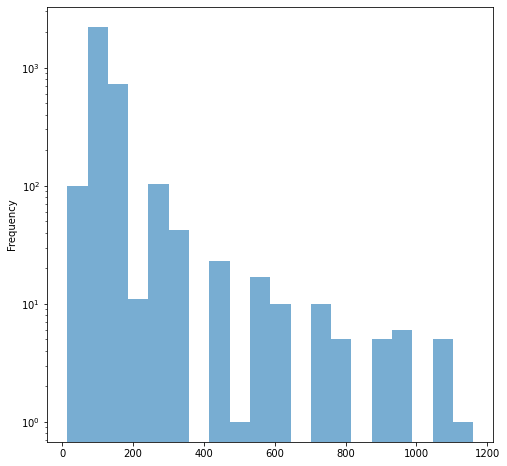

In [109]:
# how many properties overdue by days
overdue['Days'].plot.hist(bins=20, alpha=0.6, figsize=(8,8), log=True)

array([<AxesSubplot:xlabel='Days Overdue', ylabel='Num. of Properties'>],
      dtype=object)

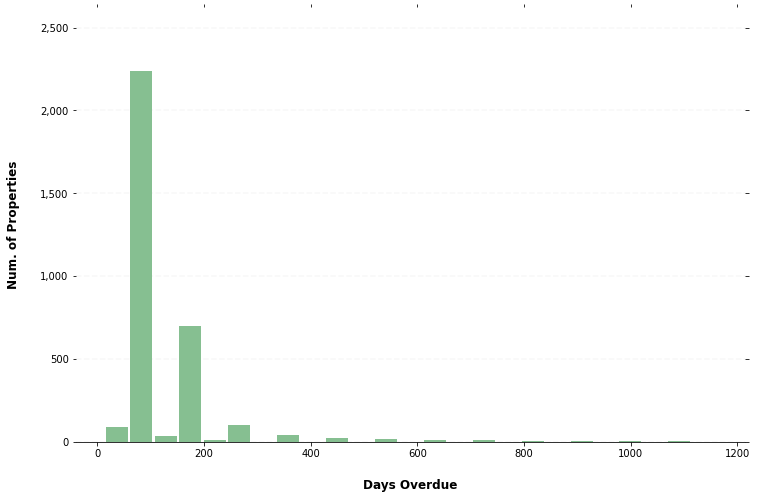

In [115]:
nice_hist(overdue, "Days Overdue", "Num. of Properties",log=False)

array([<AxesSubplot:xlabel='Days Overdue', ylabel='Num. of Properties'>],
      dtype=object)

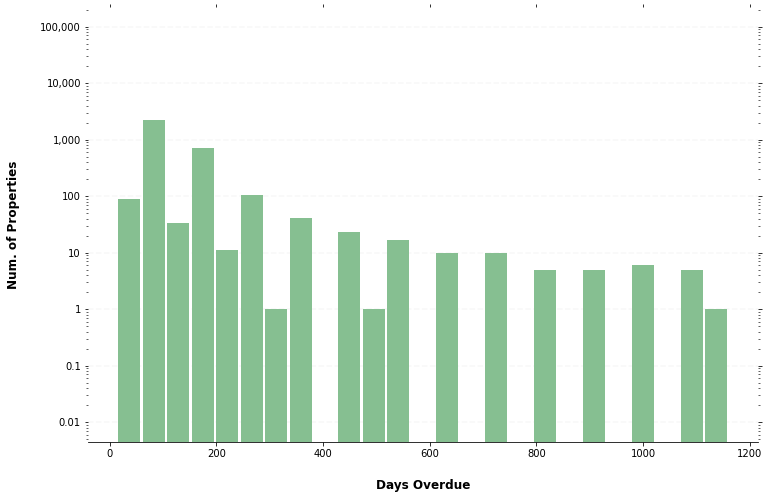

In [116]:
nice_hist(overdue, "Days Overdue", "Num. of Properties",log=True)

# who is overdue, for how long, and by how much?

In [97]:
overdue_ = overdue.groupby(['AccountNumber','PropertyLocation','Year','Qtr'])[['Days']].agg('sum')
overdue_)

Days
AccountNumber PropertyLocation Year Qtr      
596           57 ESSEX ST.     2020 4     217
                               2021 1     170
                                    2      80
604           26 GREENE ST.    2020 4     217
                               2021 1     325
...                                       ...
678715        15 FULTON AVE.   2021 2      80
678780        250 FIRST ST.    2021 1     170
                                    2      80
678850        140 BAY ST.      2021 1     170
                                    2      80

[3017 rows x 1 columns]

## TODO flatten the groupby into a new dataframe
### columns = tax periods
### rows = properties
### values = Days (late)

***

# scraps

## late balances by tax bill period

In [45]:
overdue = taxes[ (taxes['OpenBalance'] > 0) & (taxes_['Description'] == 'TAXES BILL') ]
overdue.head()

,property_id,OwnersName,PropertyLocation,Year,Qtr,TrDueDate,Description,Billed,Paid,OpenBalance,Days,InterestDue,pams_pin
0,1,CITY OF JERSEY CITY,20 HUDSON ST.,2031,4,2031-11-01,TAXES BILL,0.0,0.0,6.36,0,0.0,0901_14502_00011
2,1,CITY OF JERSEY CITY,20 HUDSON ST.,2031,3,2031-08-01,TAXES BILL,0.0,0.0,8.51,0,0.0,0901_14502_00011
7,1,CITY OF JERSEY CITY,20 HUDSON ST.,2031,1,2031-02-01,TAXES BILL,0.0,0.0,1402.71,0,0.0,0901_14502_00011
9,1,CITY OF JERSEY CITY,20 HUDSON ST.,2030,4,2030-11-01,TAXES BILL,0.0,0.0,108.30,0,0.0,0901_14502_00011
14,1,CITY OF JERSEY CITY,20 HUDSON ST.,2030,2,2030-05-01,TAXES BILL,0.0,0.0,108.30,0,0.0,0901_14502_00011


In [70]:
# https://stackoverflow.com/questions/39922986/pandas-group-by-and-sum
# df.groupby(['Name', 'Fruit'])[['Number']].agg('sum')

# first list is fields to groupby, 2nd is column to agg

overdue.groupby(['TrDueDate','Days'])[['OpenBalance']].agg('sum')

# appears that 'days' is calculated relative to today? e.g. open balance is running ledger


OpenBalance
TrDueDate  Days             
2014-08-01 0          143.72
2015-05-01 0         1265.58
2017-08-01 0         1016.70
2018-05-01 0           83.05
           1160        56.78
2018-08-01 1070       543.88
2018-11-01 980        591.56
2019-02-01 890        334.14
2019-05-01 0          415.70
           800        348.20
2019-08-01 0         5705.41
           710       5916.43
2019-11-01 0         6068.23
           620       5906.69
2020-02-01 0        31814.35
           530       5998.62
2020-05-01 0        14138.39
           440       6402.79
2020-08-01 0       183645.08
           350      91022.01
2020-11-01 0       387125.91
           260     118155.68
2021-02-01 0       851583.43
           170     728975.92
2021-05-01 0      1149757.72
           80     1653412.30
2021-08-01 0      4653583.88
2021-11-01 0      1039718.43
2022-02-01 0        29763.65
2022-05-01 0         3023.65
2022-08-01 0         1497.52
2022-11-01 0         1066.62
2023-02-01 0         1066.62
2023-05-01 0          687.52
2023-08-01 0          522.92
2023-11-01 0          836.18
2024-02-01 0          490.00
2024-05-01 0          300.00
2026-11-01 0          305.76
2027-02-01 0         1108.34
2027-05-01 0         3752.20
2027-08-01 0         1108.34
2028-05-01 0          855.37
2028-11-01 0          900.00
2029-02-01 0           20.00
2030-05-01 0          108.30
2030-11-01 0          108.30
2031-02-01 0         1402.71
2031-08-01 0            8.51
2031-11-01 0            6.36

# mapping starts

In [ ]:
# join the geometry from the shapefile to the taxes table based on pamspin

In [ ]:
import geopandas as gpd
import folium

In [ ]:
parcelmap=gpd.read_file('../../_GIS/base_maps/NJ/_017_HUDSON/parcels_shp_dbf_Hudson/HudsonCountyParcels.shp')
parcelmap.head()

In [ ]:
# %matplotlib inline
# parcelmap.plot(color='black')